Example of using a hierarchy of surveys and the blob scheduler

In [1]:
import numpy as np
import lsst.sims.featureScheduler as fs
from lsst.sims.speedObservatory import Speed_observatory
import matplotlib.pylab as plt
import healpy as hp
from lsst.sims.utils import _hpid2RaDec
import time

import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles

t0 = time.time()

/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/utils.py:27: UserWarning: Could not import ts.scheduler. This is required to load the FieldsDatabase. In this case
it will fallback to loading fields from the local "fieldID.lis" file.
  it will fallback to loading fields from the local "fieldID.lis" file.''')


In [2]:
survey_length = 20.1  # days
nside = fs.set_default_nside(nside=32)

years = np.round(survey_length/365.25)
# Define what we want the final visit ratio map to look like
target_map = fs.standard_goals(nside=nside)
# Compute the normalization factor for the basis function.
norm_factor = fs.calc_norm_factor(target_map)
# List to hold all the surveys (for easy plotting later)
surveys = []

# Set up observations to be taken in blocks. Take (g,r), (r,i), or (g,i). Also take
# unpaired blocks of u, z, or y.
filter1s = ['u', 'g', 'r', 'i', 'z', 'y']
filter2s = [None, 'r', 'i', 'g', None, None]
pair_surveys = []
for filtername, filtername2 in zip(filter1s, filter2s):
    bfs = []
    bfs.append(fs.M5_diff_basis_function(filtername=filtername, nside=nside))
    if filtername2 is not None:
        bfs.append(fs.M5_diff_basis_function(filtername=filtername2, nside=nside))
    bfs.append(fs.Target_map_basis_function(filtername=filtername,
                                            target_map=target_map[filtername],
                                            out_of_bounds_val=hp.UNSEEN, nside=nside,
                                           norm_factor=norm_factor))
    if filtername2 is not None:
        bfs.append(fs.Target_map_basis_function(filtername=filtername2,
                                            target_map=target_map[filtername2],
                                            out_of_bounds_val=hp.UNSEEN, nside=nside,
                                               norm_factor=norm_factor))
    bfs.append(fs.Slewtime_basis_function(filtername=filtername, nside=nside))
    bfs.append(fs.Zenith_shadow_mask_basis_function(nside=nside))
    weights = np.array([3.0, 3.0, .3, .3, 3., 0.])
    if filtername2 is None:
        # Need to scale weights up so filter balancing still works. 
        weights = np.array([6.0, 0.6, 3., 0.])
    # XXX-
    # This is where we could add a look-ahead basis function to include m5_diff in the future.
    # Actually, having a near-future m5 would also help prevent switching to u or g right at twilight?
    # Maybe just need a "filter future" basis function? 
    if filtername2 is None:
        survey_name = 'blob, %s' % filtername
    else:
        survey_name = 'blob, %s%s' % (filtername, filtername2)
    surveys.append(fs.Blob_survey(bfs, weights, filtername=filtername, filter2=filtername2,
                                   dither=True, nside=nside, ignore_obs='DD',
                                   survey_note=survey_name))
    pair_surveys.append(surveys[-1])


# Let's set up some standard surveys as well to fill in the gaps. This is my old silly masked version.
# It would be good to put in Tiago's verion and lift nearly all the masking. That way this can also
# chase sucker holes.
#filters = ['u','g', 'r','i', 'z', 'y']
# let's say you can only fill in with red filters at twilight
filters = ['i', 'z', 'y']
greedy_surveys = []
for filtername in filters:
    bfs = []
    bfs.append(fs.M5_diff_basis_function(filtername=filtername, nside=nside))
    bfs.append(fs.Target_map_basis_function(filtername=filtername,
                                            target_map=target_map[filtername],
                                            out_of_bounds_val=hp.UNSEEN, nside=nside,
                                           norm_factor=norm_factor))

    bfs.append(fs.North_south_patch_basis_function(zenith_min_alt=50., nside=nside))
    bfs.append(fs.Slewtime_basis_function(filtername=filtername, nside=nside))
    bfs.append(fs.Strict_filter_basis_function(filtername=filtername))

    weights = np.array([3.0, 0.3, 1., 3., 3.])
    # Might want to try ignoring DD observations here, so the DD area gets covered normally--DONE
    surveys.append(fs.Greedy_survey_fields(bfs, weights, block_size=1, filtername=filtername,
                                           dither=True, nside=nside, ignore_obs='DD'))
    greedy_surveys.append(surveys[-1])

# Set up the DD surveys
#dd_surveys = []
dd_surveys = fs.generate_dd_surveys()
surveys.extend(dd_surveys)


#survey_list_o_lists = [pair_surveys, greedy_surveys]
# As a list-of lists, this will check for DD observations, if none, check for a blob survey,
# and if none, check the regular greedy surveys.
survey_list_o_lists = [dd_surveys, pair_surveys, greedy_surveys]

In [3]:
# Debug to stop at a spot if needed
n_visit_limit = None

# put in as list-of-lists so pairs get evaluated first.
scheduler = fs.Core_scheduler(survey_list_o_lists, nside=nside)
observatory = Speed_observatory(nside=nside, quickTest=True)
observatory, scheduler, observations = fs.sim_runner(observatory, scheduler,
                                                     survey_length=survey_length,
                                                     filename='blobs_%iyrs.db' % years,
                                                     delete_past=True, n_visit_limit=n_visit_limit)

/Users/yoachim/gitRepos/sims_seeingModel/python/lsst/sims/seeingModel/seeingModel.py:133: RuntimeWarning: invalid value encountered in power
  airmass_correction = np.power(airmass, 0.6)


progress = 42.7%

/Users/yoachim/gitRepos/sims_skybrightness_pre/python/lsst/sims/skybrightness_pre/SkyModelPre.py:313: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn('Requested MJD between sunrise and sunset, returning closest maps')
/Users/yoachim/gitRepos/sims_skybrightness_pre/python/lsst/sims/skybrightness_pre/SkyModelPre.py:229: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn('Requested MJD between sunrise and sunset, returning closest maps')


progress = 99.9%Skipped 0 observations
Completed 11036 observations


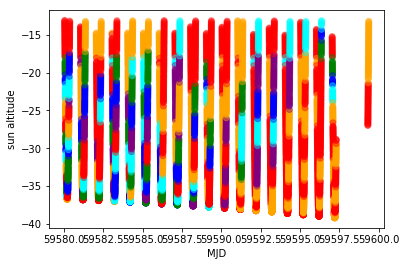

In [4]:
# The poor man's hourglass plot.
filter2color = {'u': 'purple', 'g': 'blue', 'r': 'green',
                             'i': 'cyan', 'z': 'orange', 'y': 'red'}
color_convert = [filter2color[filtername] for filtername in observations['filter']]
plt.scatter(observations['mjd'], observations['sunAlt'], c=color_convert, alpha=.4)
plt.xlabel('MJD')
plt.ylabel('sun altitude')
#plt.xlim([observations['mjd'].min()+1, observations['mjd'].min()+5.4])
#plt.xlim([59695, 59710])

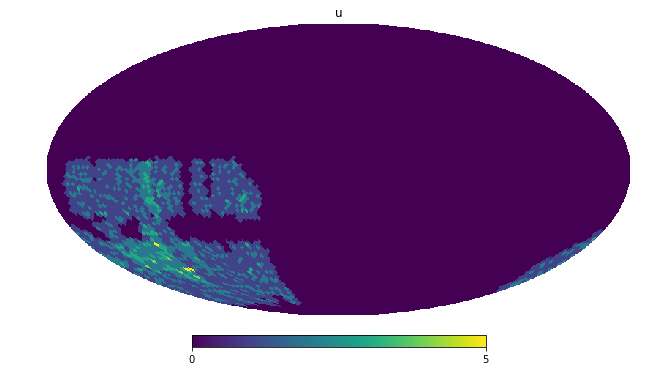

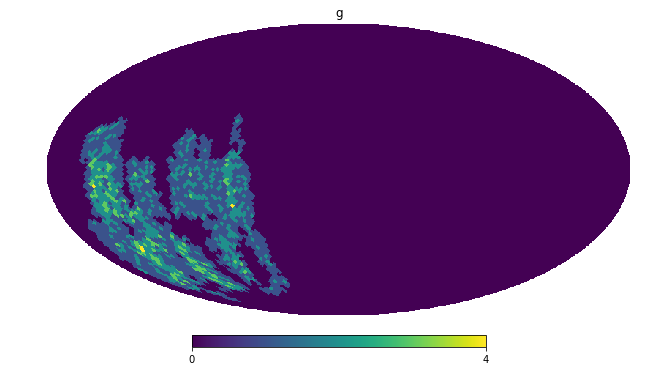

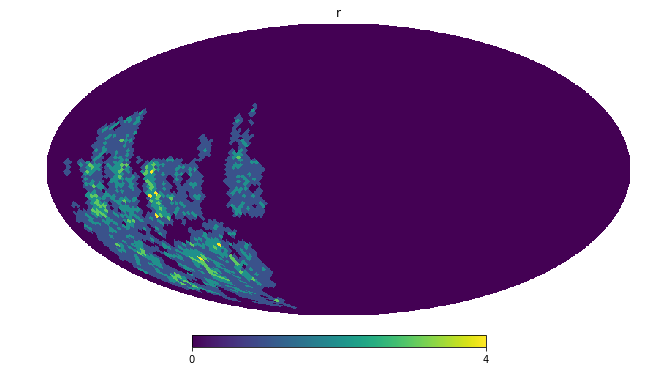

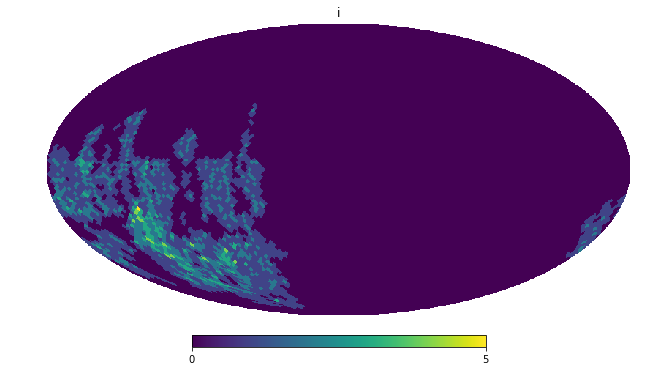

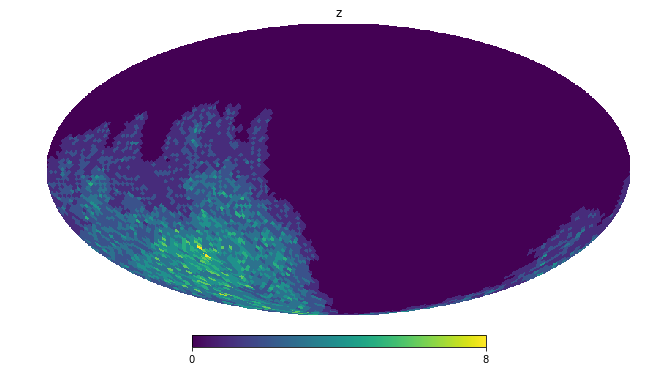

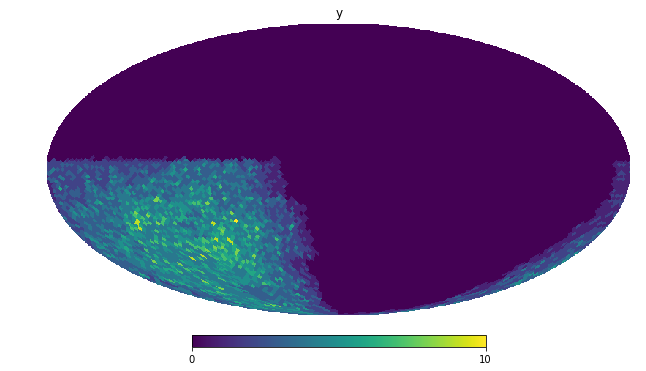

In [5]:
nfill = len(filters)
for survey in surveys[0:6]:
    if survey.filter2 is None:
        i=1
    else:
        i=2
    fn = survey.basis_functions[i].survey_features['N_obs'].filtername
    hp.mollview(survey.basis_functions[i].survey_features['N_obs'].feature, title=fn)


In [6]:
# Figure out how many DD fields we got
u_notes = np.unique(observations['note'])
dd_surveys = [note for note in u_notes if 'DD' in note]
dd_surveys
dd_obs = 0
for dd_survey in dd_surveys:
    dd_obs += np.size(np.where(observations['note'] == dd_survey)[0])

In [7]:

print('total number of obs=%i' % np.size(observations))
print('number of greedy observations=%i' % np.size(np.where(observations['note'] == '')[0]))
print('number of DD observations = %i' % dd_obs)

total number of obs=11036
number of greedy observations=1356
number of DD observations = 642


In [8]:
min_gap = 15.
max_gap = 35.
survey_roots = ['blob, gr', 'blob, ri', 'blob, gi']
print('survey name, n tot, n missed, n out of range')
for survey_root in survey_roots:
    s1 = np.where((observations['note'] == survey_root+', a') | (observations['note'] == survey_root+', b'))[0]
    ublock = np.unique(observations['block_id'][s1])[1:]
    n_missed = ublock*0
    n_out_range= ublock*0

    for i,blockid in enumerate(ublock):
        good = np.where(observations['block_id'][s1] == blockid)
        observations['note'][s1][good]
        a_half = np.where(observations['note'][s1][good] == survey_root+', a')[0]
        b_half = np.where(observations['note'][s1][good] == survey_root+', b')[0]
        n_missed[i] = a_half.size - b_half.size
        tdiff = observations['mjd'][s1][good][b_half] - observations['mjd'][s1][good][a_half][0:b_half.size]
        tdiff *=24.*60  # to minutes
        n_out_range[i] += np.size(np.where(tdiff < min_gap)[0])
        n_out_range[i] += np.size(np.where(tdiff > max_gap)[0])
    print(survey_root, np.size(s1), np.sum(n_missed), np.sum(n_out_range))

survey name, n tot, n missed, n out of range
blob, gr 932 0 0
blob, ri 726 0 0
blob, gi 0 0 0


In [9]:
# Check how many of the other blobs got executed
print('survey name, number of obs')
for name in ['blob, u', 'blob, y', 'blob, z']:
    print(name, np.where(observations['note']==name)[0].size)

survey name, number of obs
blob, u 952
blob, y 3134
blob, z 2462


In [10]:
np.mean(observations['slewtime']), np.median(observations['slewtime'])

(11.314526304990087, 6.7554931305548553)

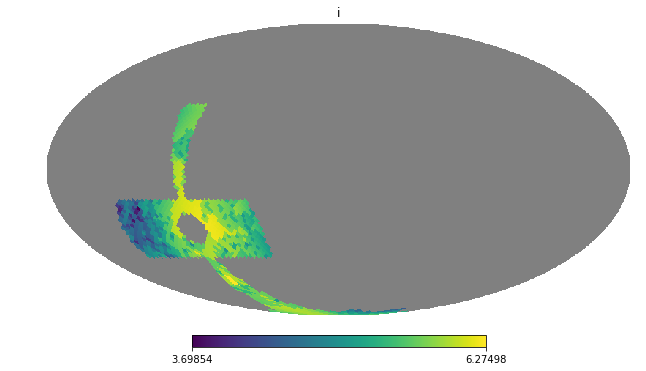

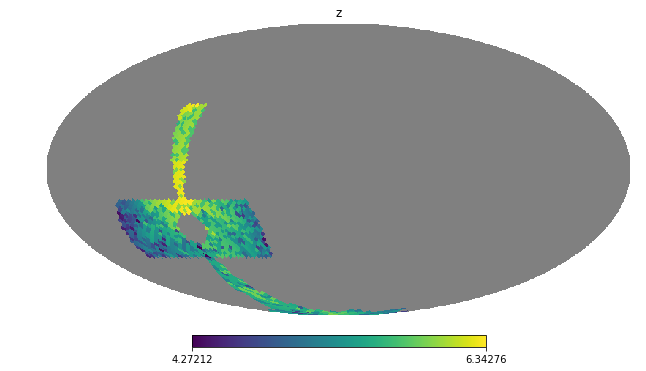

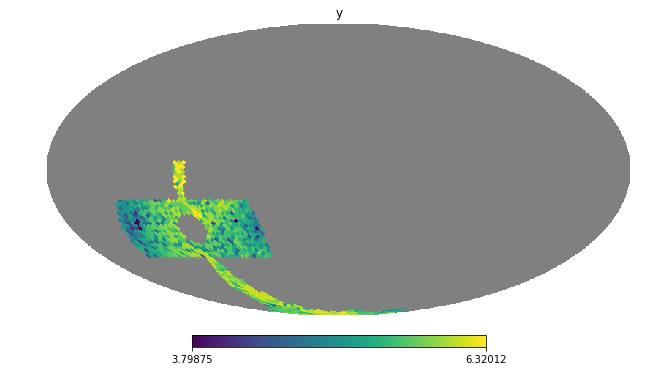

In [11]:
for survey in greedy_surveys:
    rw = survey.calc_reward_function()
    if np.size(rw) > 1:
        hp.mollview(rw, title=survey.filtername)

In [12]:
status = observatory.return_status()
lmst = status['lmst']
lat = observatory.site.latitude_rad

/Users/yoachim/gitRepos/sims_seeingModel/python/lsst/sims/seeingModel/seeingModel.py:133: RuntimeWarning: invalid value encountered in power
  airmass_correction = np.power(airmass, 0.6)


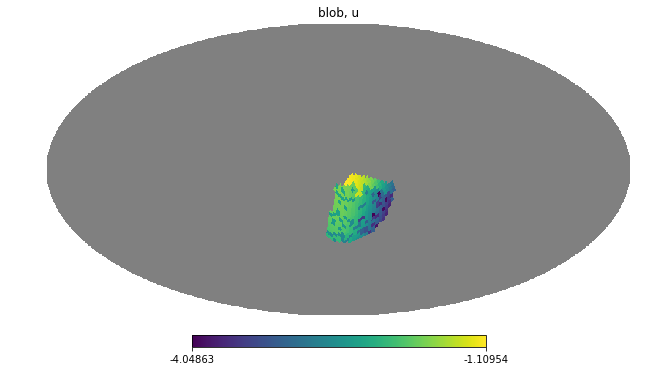

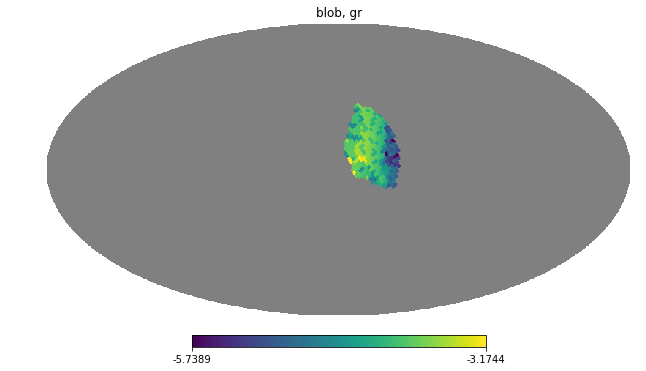

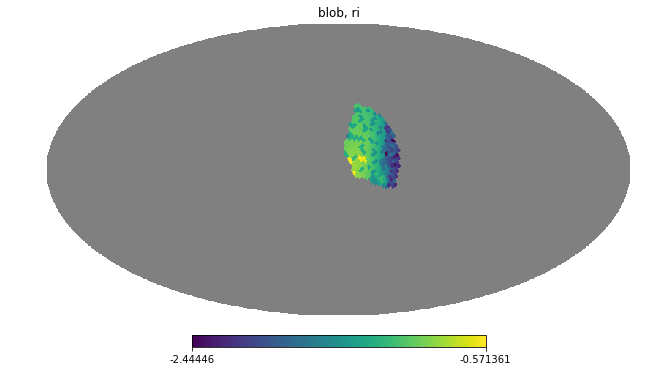

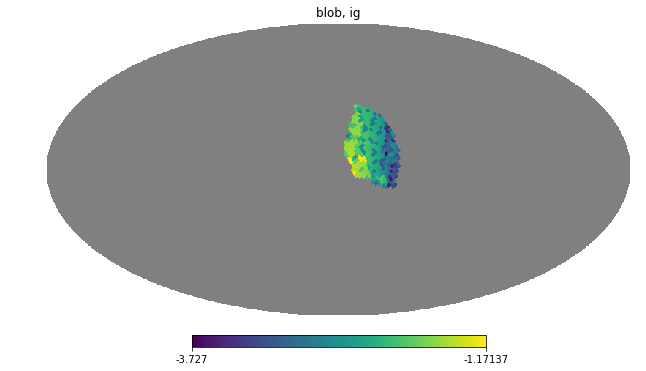

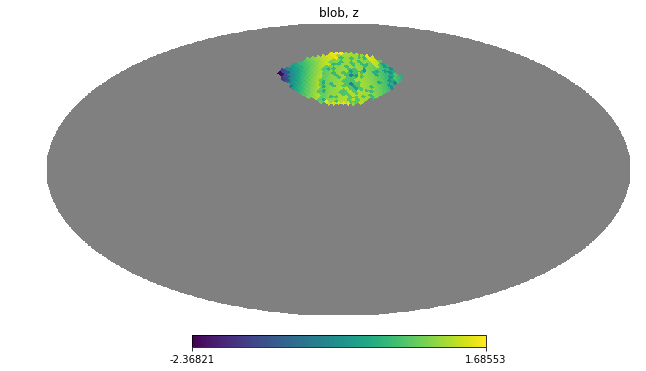

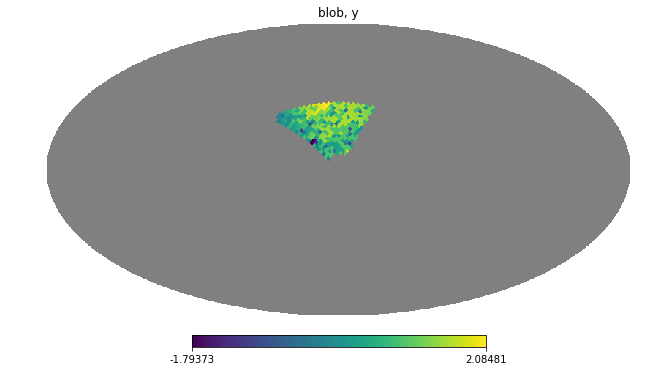

In [13]:
for survey in pair_surveys:
    rw = survey.calc_reward_function()
    if np.size(rw) > 1:
        hp.mollview(rw, title=survey.survey_note, rot=(lmst*360/24.,np.degrees(lat)))

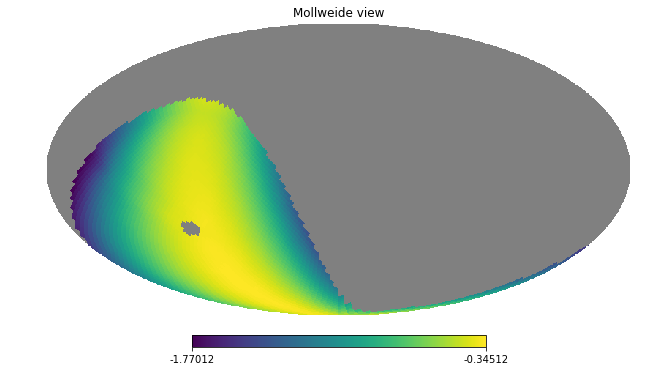

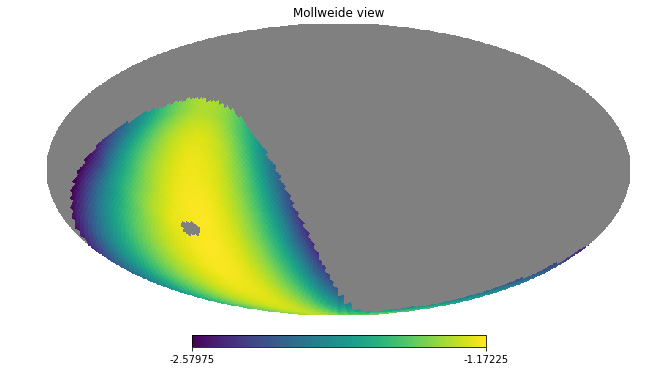

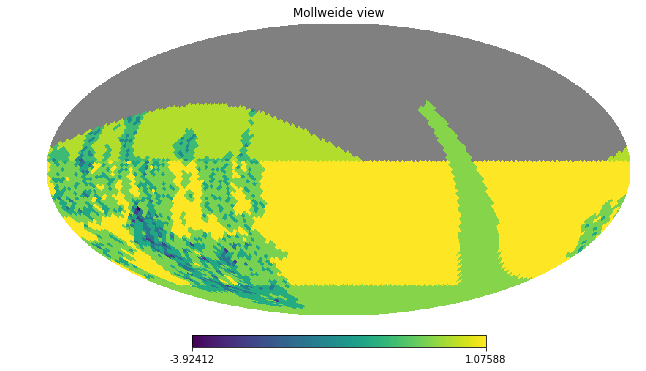

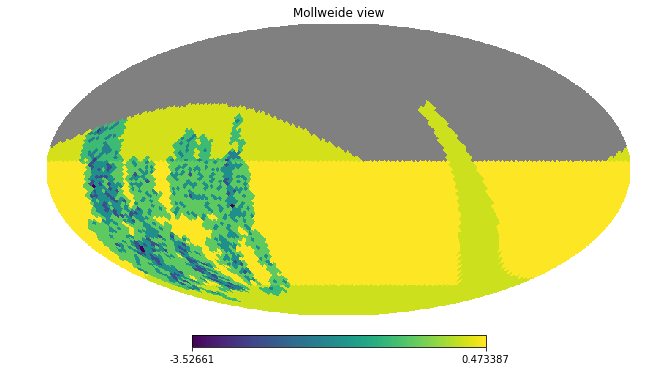

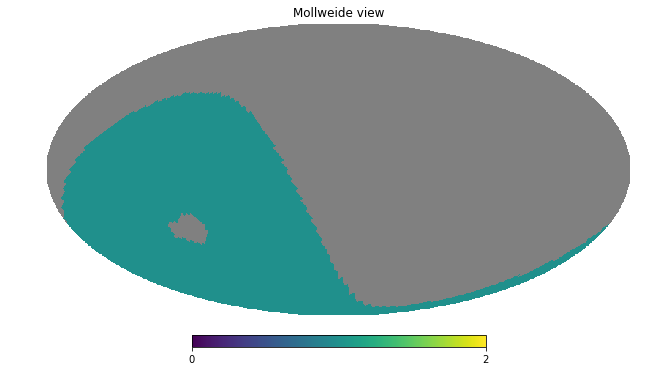

In [14]:
for bf in pair_surveys[-3].basis_functions:
    val = bf()
    if np.size(val) > 1:
        hp.mollview(val)

In [15]:
t1 = time.time()
delta_t = t1-t0
print('ran in %.1f min = %.1f hours' % (delta_t/60., delta_t/3600.))

ran in 15.3 min = 0.3 hours


In [16]:
# Let's check the pair fraction for griz
bundleList = []
metric = metrics.PairFractionMetric(mjdCol='mjd')
slicer= slicers.HealpixSlicer(nside=32, latCol='dec', lonCol='RA')
bundleList.append(metricBundles.MetricBundle(metric,slicer,''))

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


In [17]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, None, outDir='mafOut', resultsDb=None)
in_filt = np.where((observations['filter'] == 'g') |(observations['filter'] == 'r') |(observations['filter'] == 'i') )
bg.setCurrent('')
bg.runCurrent('', simData=observations[in_filt])

Running:  ['opsim_PairFraction_HEAL']


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:108: UserWarning: Warning: dbObj should be an instantiated Database (or child) object.
  warnings.warn('Warning: dbObj should be an instantiated Database (or child) object.')


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "" constraint now.


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.0820839  dipole: lon: 97.8385, lat: -16.8031, amp: 1.09607
Plotting complete.


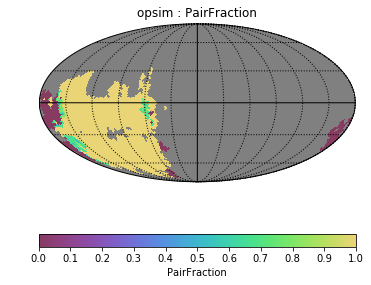

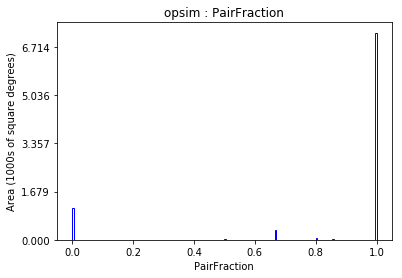

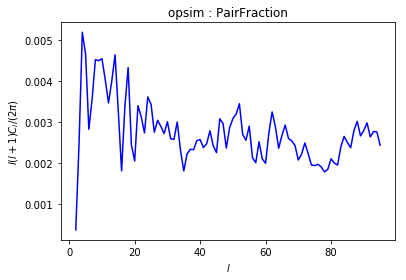

In [18]:
bg.plotAll(closefigs=False)

/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:108: UserWarning: Warning: dbObj should be an instantiated Database (or child) object.
  warnings.warn('Warning: dbObj should be an instantiated Database (or child) object.')


Running:  ['opsim_PairFraction_HEAL']


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:456: RuntimeWarning: invalid value encountered in equal
  b.metricValues.mask = np.where(b.metricValues.data == b.metric.badval,


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:60: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 0.999903  dipole: lon: 71.3506, lat: -38.9455, amp: 0.000120729
Plotting complete.


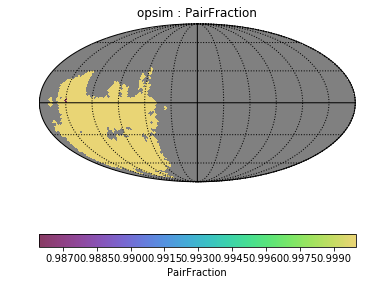

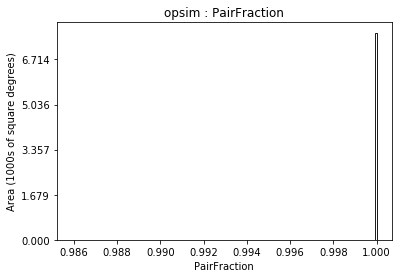

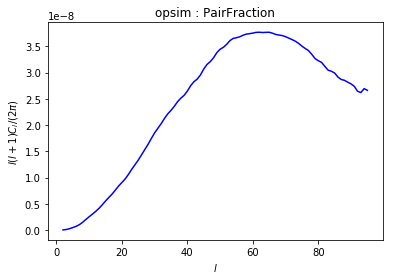

In [19]:
# OK, these are all the non-filler observations
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, None, outDir='mafOut', resultsDb=None)
in_filt = np.where((observations['note'] != '') & 
                   ((observations['filter'] == 'g') |(observations['filter'] == 'r') |(observations['filter'] == 'i')))
bg.setCurrent('')
bg.runCurrent('', simData=observations[in_filt])
bg.plotAll(closefigs=False)

In [20]:
np.unique(observations['note'])

array(['', 'DD:COSMOS', 'DD:ECDFS', 'DD:XMM-LSS', 'DD:u,COSMOS',
       'DD:u,ECDFS', 'DD:u,XMM-LSS', 'blob, gr, a', 'blob, gr, b',
       'blob, ig, a', 'blob, ig, b', 'blob, ri, a', 'blob, ri, b',
       'blob, u', 'blob, y', 'blob, z'],
      dtype='<U40')